# Forecasting

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.contrib.examples.bart import load_bart_od
from pyro.ops.stats import quantile
import pyro.distributions as dist
import pyro.poutine as poutine

import matplotlib.pyplot as plt
import torch
import pyro

%matplotlib inline
assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(20200221)

In [8]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


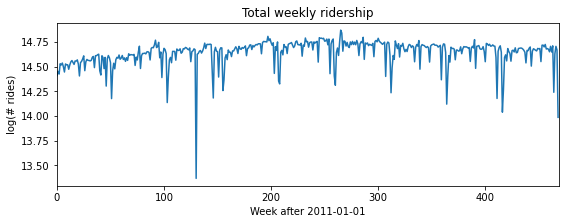

In [9]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
data = data.unsqueeze(-1)
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, len(data));

In [10]:
# First we need some boilerplate to create a class and define a .model() method.
class Model1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)  # Should be 1 in this univariate tutorial.
        feature_dim = covariates.size(-1)

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)


In [11]:
T0 = 0              # begining
T2 = data.size(-2)  # end
T1 = T2 - 52        # train/test split

In [12]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.stack([time], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 484401
INFO 	 step  100 loss = 0.609041
INFO 	 step  200 loss = -0.535145
INFO 	 step  300 loss = -0.605682
INFO 	 step  400 loss = -0.601777
INFO 	 step  500 loss = -0.607571
INFO 	 step  600 loss = -0.613538
INFO 	 step  700 loss = -0.615189
INFO 	 step  800 loss = -0.607103
INFO 	 step  900 loss = -0.611773
INFO 	 step 1000 loss = -0.59353


torch.Size([1000, 52, 1]) torch.Size([52])


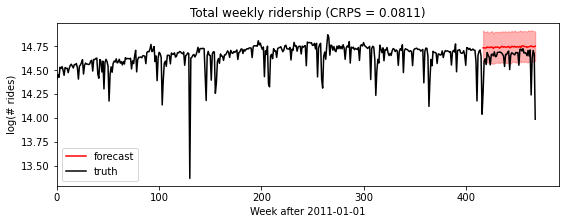

In [13]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

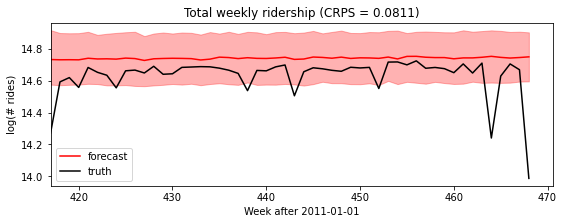

In [14]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [15]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # We'll sample a time-global scale parameter outside the time plate,
        # then time-local iid noise inside the time plate.
        drift_scale = pyro.sample("drift_scale",
                                  dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            # We'll use a reparameterizer to improve variational fit. The model would still be
            # correct if you removed this context manager, but the fit appears to be worse.
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply dependent
        # transforms outside the plate.
        motion = drift.cumsum(-2)  # A Brownian motion.

        # The prediction now includes three terms.
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # Construct the noise distribution and predict.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist, prediction)

In [16]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam = "dct",
                       )


INFO 	 step    0 loss = 1.73259e+09
INFO 	 step  100 loss = 0.935216
INFO 	 step  200 loss = -0.0716183
INFO 	 step  300 loss = -0.181082
INFO 	 step  400 loss = -0.3293
INFO 	 step  500 loss = -0.398306
INFO 	 step  600 loss = -0.346195
INFO 	 step  700 loss = -0.403714
INFO 	 step  800 loss = -0.465958
INFO 	 step  900 loss = -0.503771
INFO 	 step 1000 loss = -0.477825
